In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
sys.path.insert(0, "../")

import motiflets.motiflets as ml
from motiflets.competitors import *
from motiflets.plotting import *

import subprocess
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

import warnings
warnings.simplefilter("ignore")

# Dataset: Physiodata - EEG sleep data
    
This Physiodata - EEG sleep dataset contains a recording of an afternoon nap of a healthy, nonsmoking person, between 20 to 40 years old. Data was recorded with an extrathoracic strain belt. The dataset consists of $269.286$ points at $100hz$ corresponding to $45min$. Known motifs are so-called sleep spindles and $k$-complexes.

### References:
- [1] https://link.springer.com/content/pdf/10.1007/s004220000144.pdf
- [2] https://epubs.siam.org/doi/pdf/10.1137/1.9781611972795.41

Dataset Original Length n:  10358
Dataset Sampled Length n:  10358


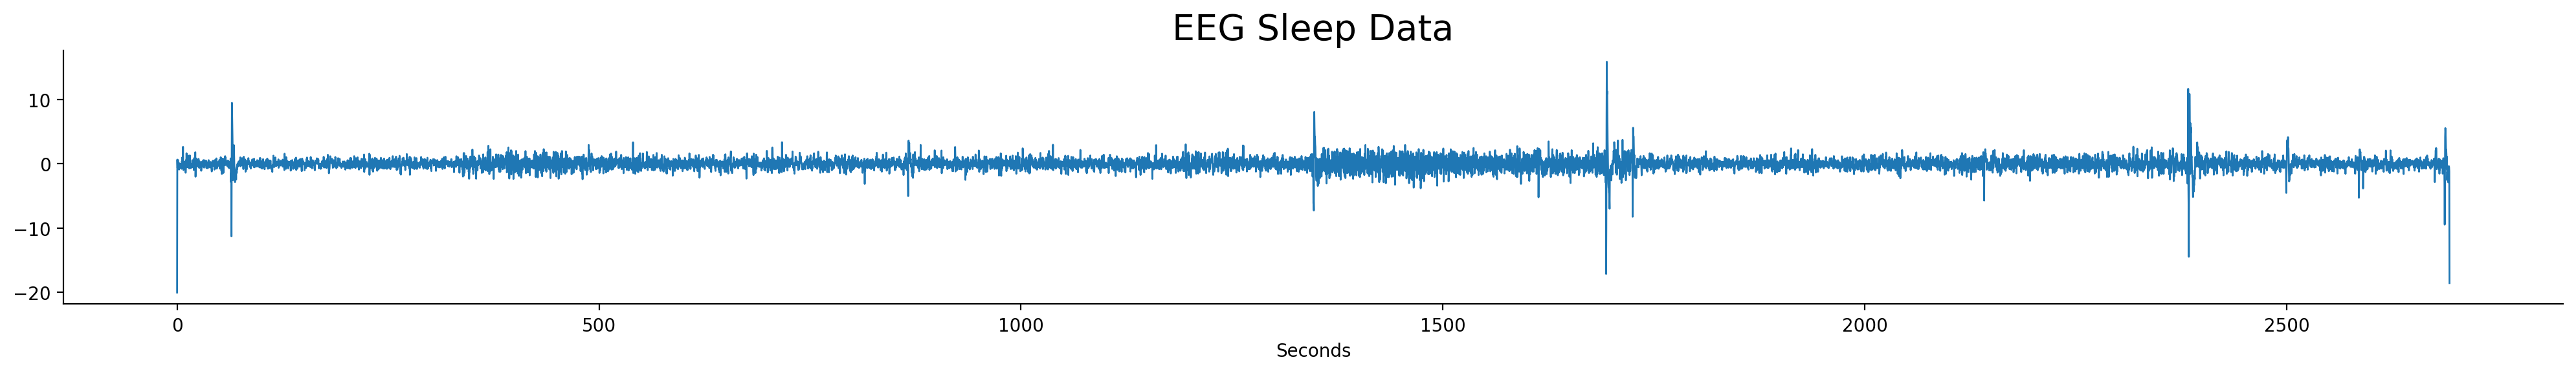

(<Figure size 2000x300 with 1 Axes>,
 [<Axes: title={'center': 'EEG Sleep Data'}, xlabel='Seconds'>])

In [2]:
file = 'npo141.csv' # Dataset Length n:  269286
ds_name="EEG Sleep Data"
series = ml.read_dataset_with_index(file) 
data = series.values
#series = ml.as_series(data, np.arange(0, 269286, 26) / 100, 'Seconds')
plot_dataset(ds_name, series)

# Known Motifs in Stage 2 sleep phases


<img src="https://upload.wikimedia.org/wikipedia/commons/7/71/Stage2sleep_new.svg">

This data set contains two main motifs: the K-Complex and  sleep spindles, two characteristic markers of stage 2 sleep.

# Parameters

In [3]:
df = pd.DataFrame() # TOP-1
df2 = pd.DataFrame() # TOP-2

rerun_all_jars = False
motif_length = 25 # we set a reasonable length around 6.5 seconds
print("Motif Length", series.index[motif_length], "seconds")

ks = 20
dataset = os.getcwd() + '/../datasets/' + file
print(dataset)


Motif Length 6.5 seconds
/Users/bzcschae/workspace/motiflets_paper/notebooks/../datasets/npo141.csv


# k-Motiflets

## We learn the size k of the motif set

We plot the similarity of the motifs as a function of the cardinality of $k$-Motiflets to their extent. Elbow points represent large changes in similarity of the found motif set, indicative of a concept change from calibrations signal to heartbeats.

In the following plots, we found two characteristic motifs: 
sleep spindles with k=15 repetitions and K-komplexes with k=13 repetitions.

Data 10358


Compute ks (20):   0%|          | 0/18 [00:00<?, ?it/s]

Chosen window-size: 25 in 10.1 s
Elbow Points [13 15]
Data 10358


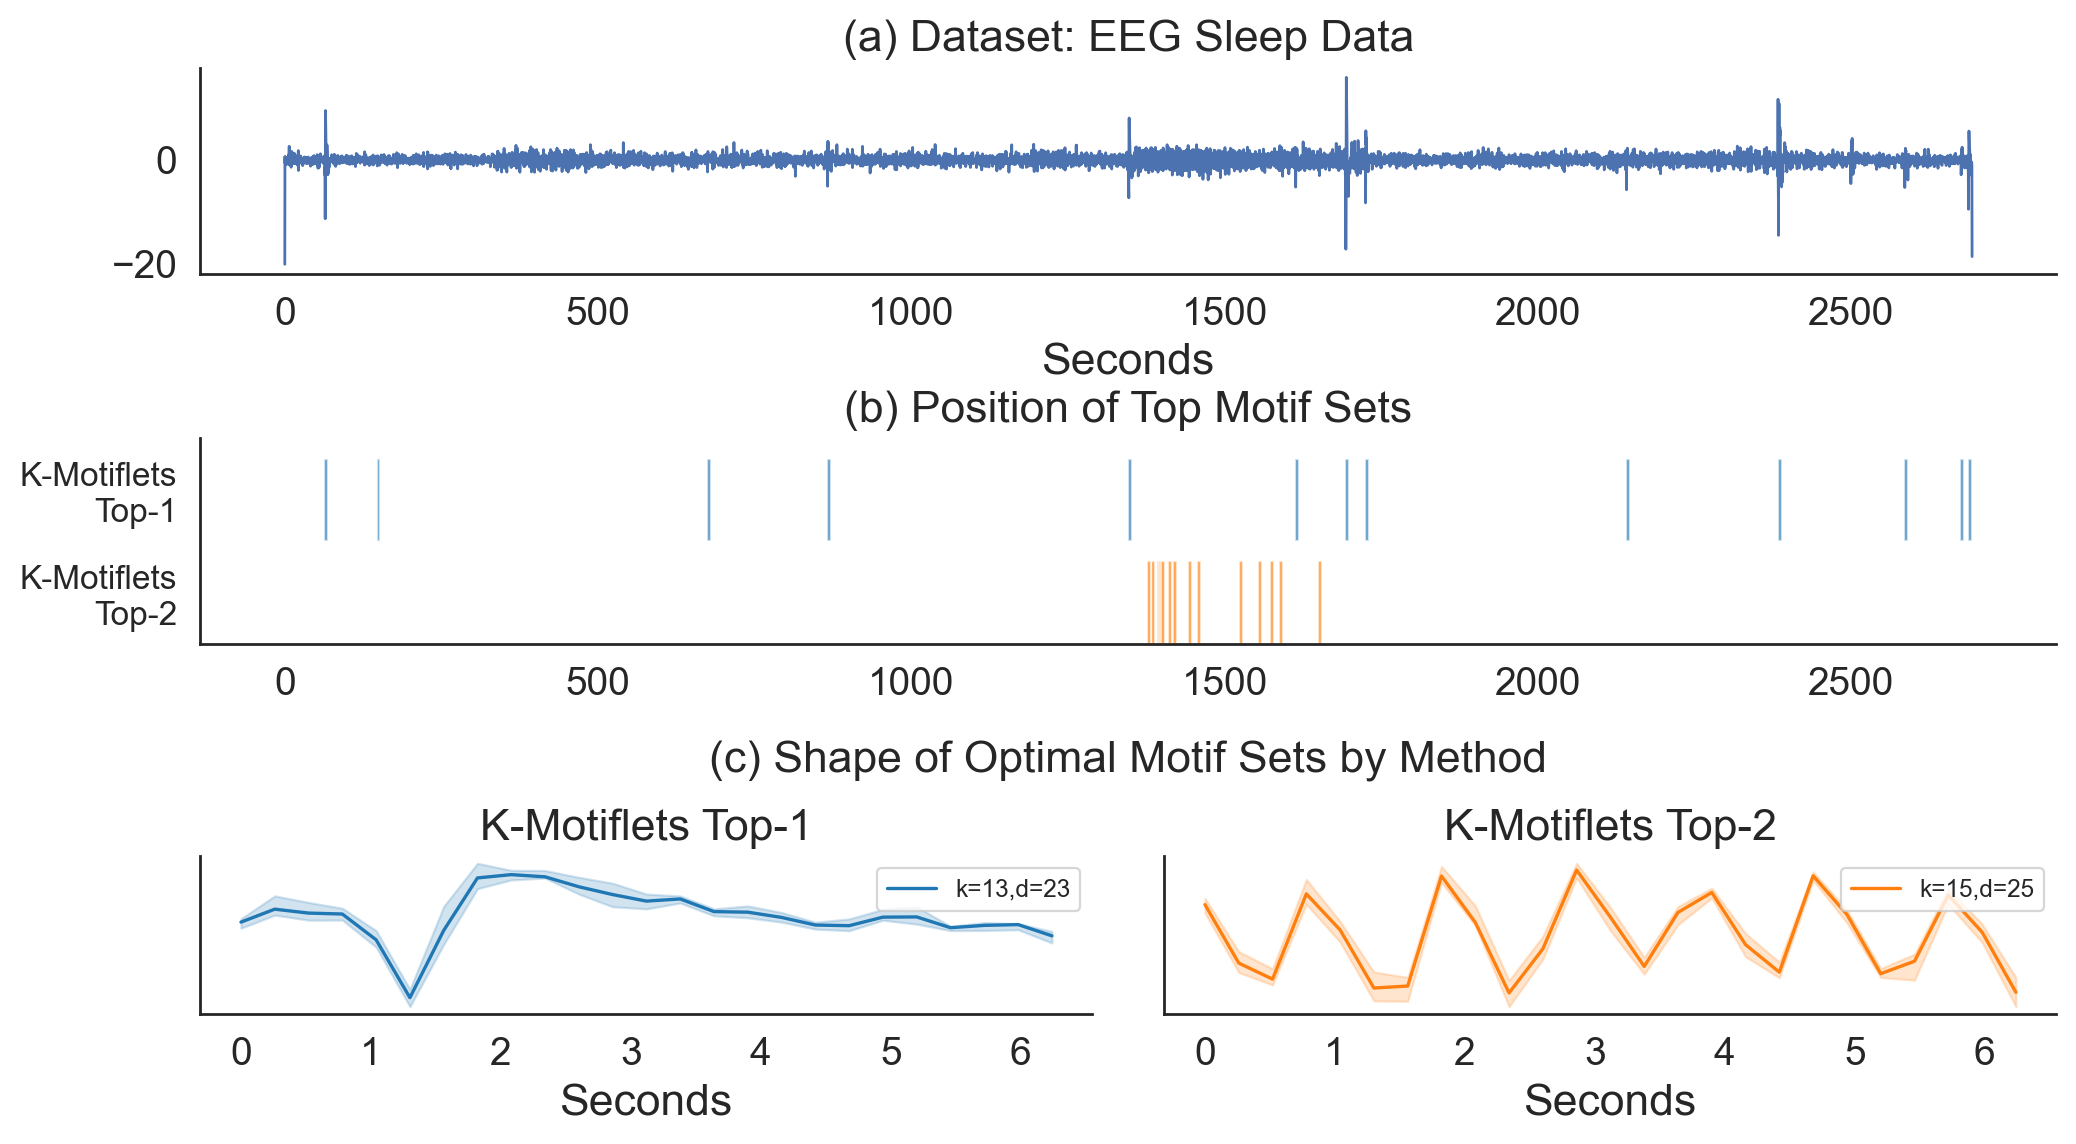

In [4]:
dists, motiflets, elbow_points = plot_elbow(
    ks, series, ds_name=ds_name, plot_elbows=False,
    motif_length=motif_length, method_name="K-Motiflets")

# Oracle

The competitor methods have two input parameters: length l and the radius r. These have to be tuned using trial-and-error. 

We use the results of $k$-Motiflets as silver standard and compare the ability of the other methods to recover the respective motifs. To enable such a comparison, we provided the competitors with proper values of $r$ and $l$, derived from the silver standard, but also with an added noise of $-10\%$ and $+10\%$ to reflect trial-and-error tuning.

In [5]:
D_full = ml.compute_distances_full(data, motif_length)

df["Motiflets Top-1"] = [motiflets[elbow_points[-1]]]
df2["Motiflets Top-2"] = [motiflets[elbow_points[-2]]]

r_top2 = ml.get_radius(D_full, motiflets[elbow_points[-1]])
r_top1 = ml.get_radius(D_full, motiflets[elbow_points[-2]])

print("Radius r of TOP-2 Motifs", r_top1, r_top2)
print("Extent d of TOP-1 Motif", ml.get_pairwise_extent(D_full, motiflets[elbow_points[-1]]))

radii = np.array([r_top2, r_top1])
print("Radii r", radii)

print("Best Radii\t", radii)
print("Best Lengths\t", motif_length)

# Human error due to trial-and-error
errors = [0, -0.10, 0.10]

Radius r of TOP-2 Motifs 14.234710693359375 12.274670600891113
Extent d of TOP-1 Motif 25.604524612426758
Radii r [12.2746706  14.23471069]
Best Radii	 [12.2746706  14.23471069]
Best Lengths	 25


# Competitors

We compare our $k$-Motiflets to the state-of-the-art motif set discovery methods. These are based on different definitions as follow:

<img src="images/motif_definitions.png"/>

# Set Finder
Runs java code:
- https://sites.google.com/site/timeseriesmotifsets/

In [6]:
rs = np.array([r_top2, r_top1*0.94])
mls = motif_length

if rerun_all_jars:
    for e in errors:
        rs = rs * (1.0 * (1+e))
        mls = np.int32(motif_length * (1-e))
        output = subprocess.call(['java', '-jar', 
           '../jars/set_finder.jar',
           dataset,
           'SetFinder',
           str(list(rs)),
           str(mls)])

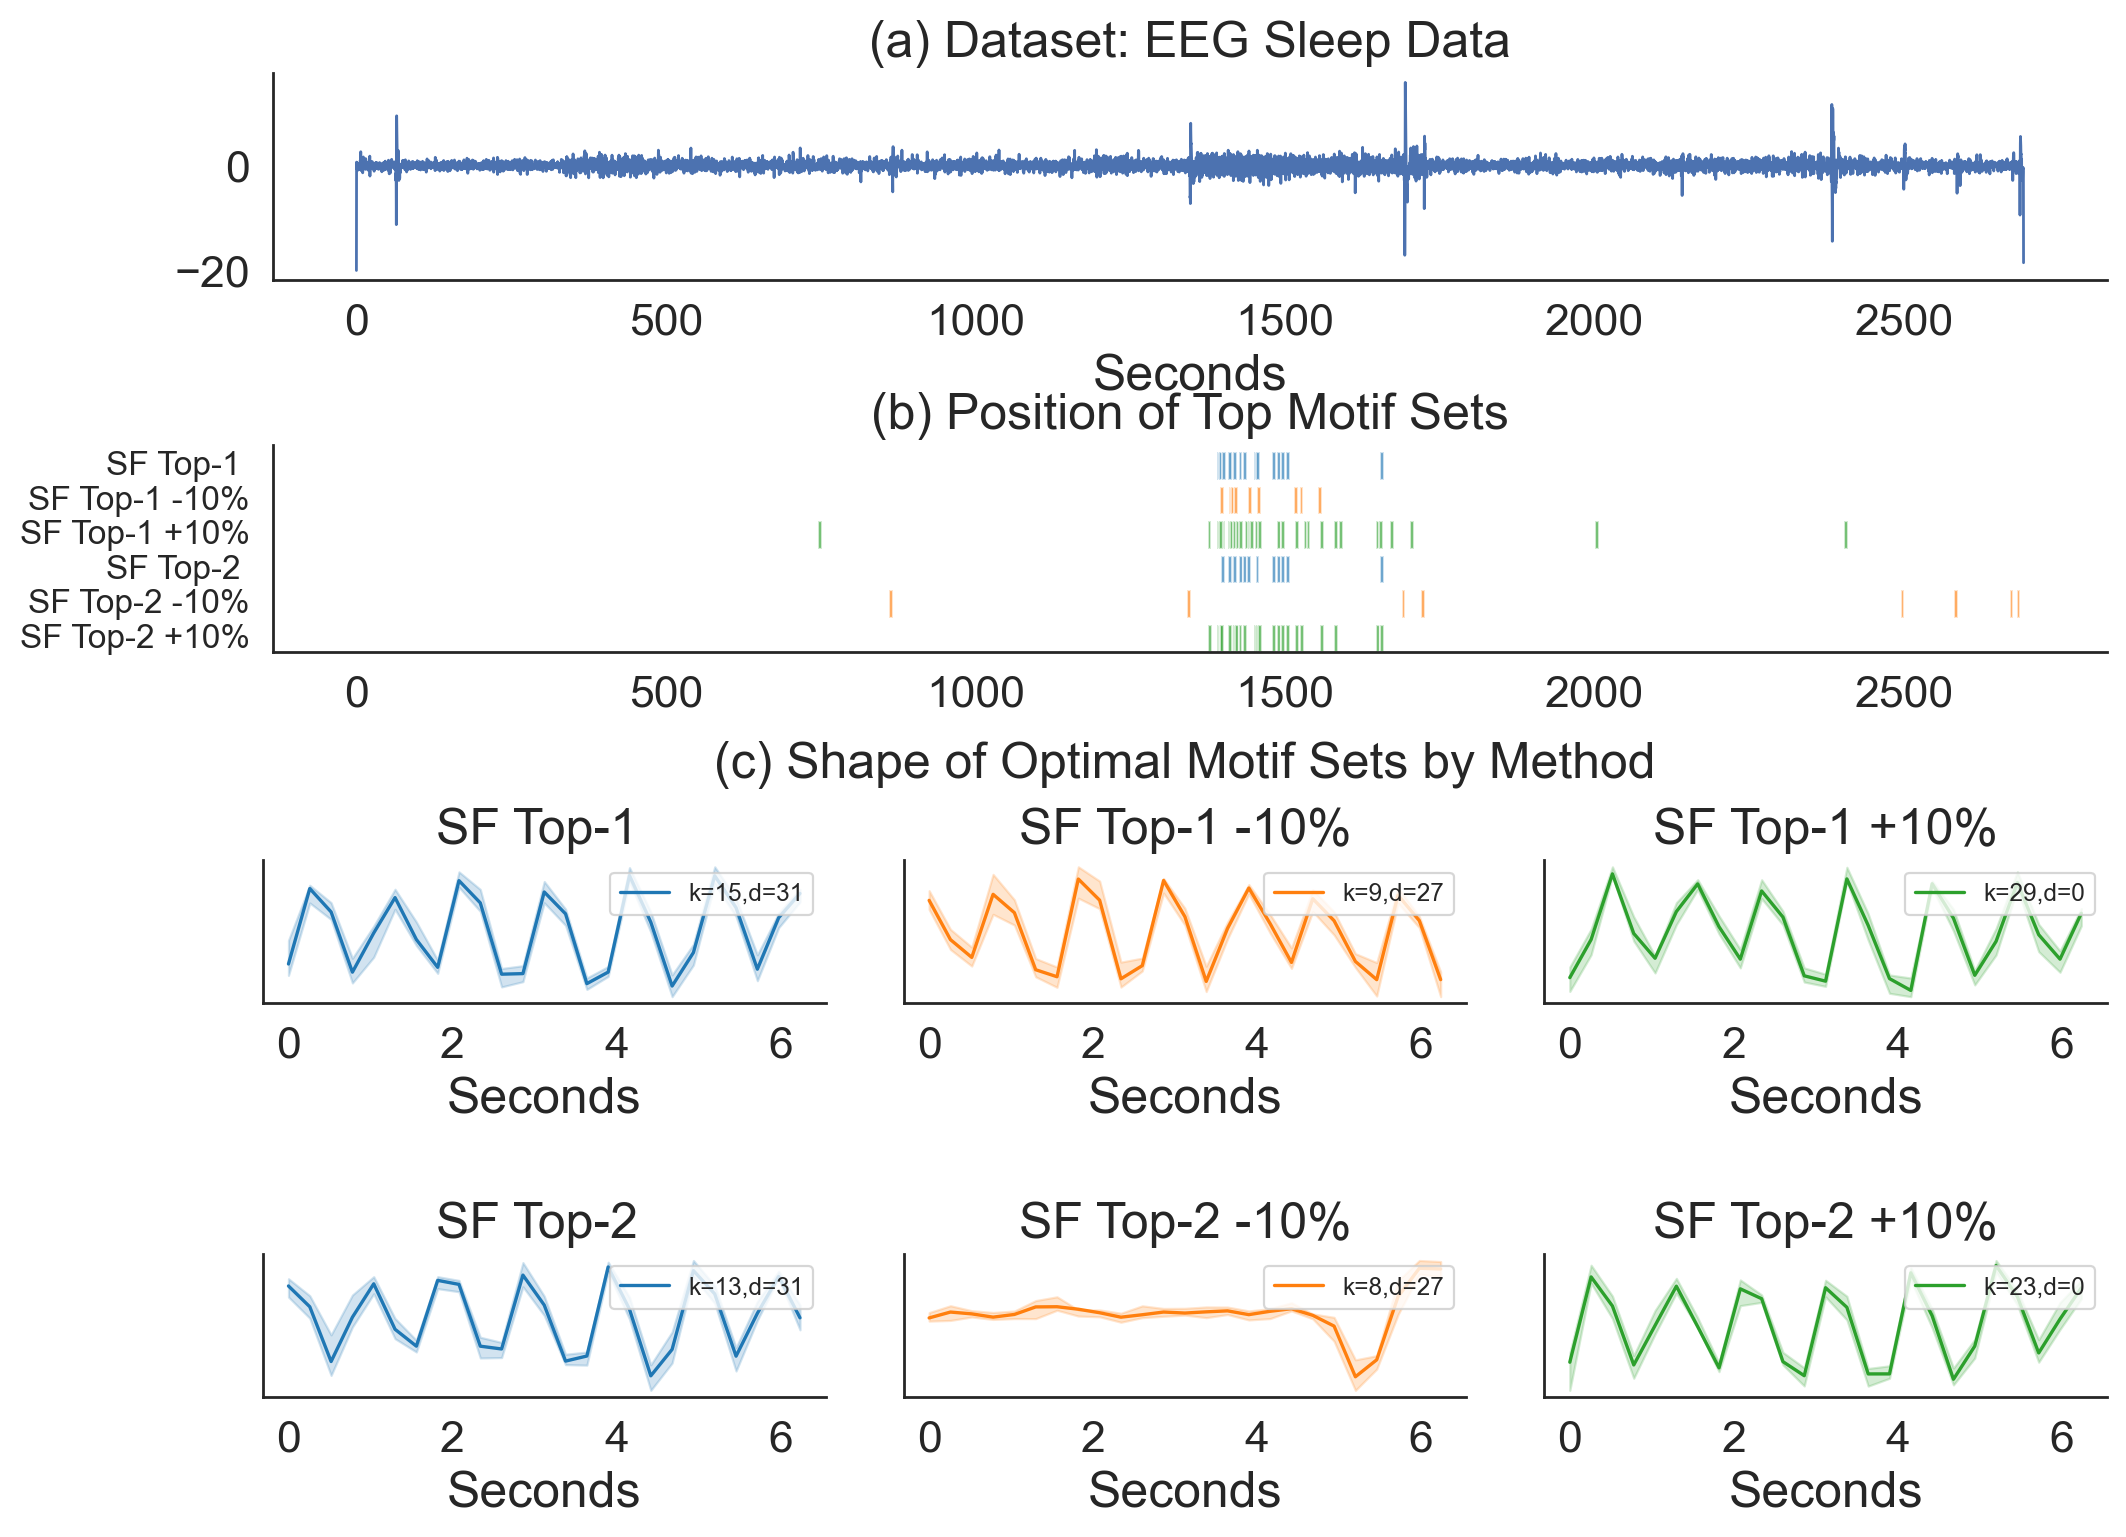

In [7]:
ms_all = {
    "" : [
	[5431, 5373, 5416, 5446, 5481, 5510, 5534, 5586, 5690, 5722, 5744, 5778, 6360],
	[5430, 5346, 5361, 5376, 5415, 5445, 5480, 5509, 5577, 5589, 5689, 5721, 5743, 5777, 6359],
    ], 
    "-10%" :[
    [6493, 3311, 5160, 6614, 9593, 9924, 10270, 10314],
	[5420, 5366, 5435, 5450, 5542, 5594, 5823, 5859, 5976],        
    ],   
    "+10%" :[
    [5430, 5289, 5346, 5357, 5368, 5415, 5445, 5456, 5480, 5509, 5577, 5589, 5604, 5689, 5721, 5743, 5777, 5833, 5865, 5986, 6074, 6336, 6359],
	[5375, 2866, 5288, 5345, 5360, 5414, 5425, 5444, 5463, 5483, 5520, 5536, 5551, 5584, 5603, 5720, 5746, 5832, 5888, 5903, 5985, 6073, 6106, 6335, 6354, 6419, 6546, 7693, 9244],        
    ]
}


motifsets = to_df(ms_all, "SF", df, df2)
plot_all_competitors(series, ds_name, motifsets.offsets.values, motif_length,
                     method_names=motifsets.index.values)

SF mostly found the sleep spindes as TOP-1 and TOP-2 motif. With slightly different parameterization it found at most $k=8$ K-Complexes as TOP-2 (out of $k=13$)

# EMMA

Runs Java Code
- https://github.com/jMotif/SAX

In [8]:
rs = np.array([r_top2*1.15, r_top1*1.02561])
mls = motif_length

if rerun_all_jars:
    for e in errors:
        rs = rs * (1.0 * (1+e))
        mls = np.int32(motif_length * (1-e))
        output = subprocess.call(['java', '-jar', 
           '../jars/emma.jar',
           dataset,
           str(list(rs)),
           str(mls)])

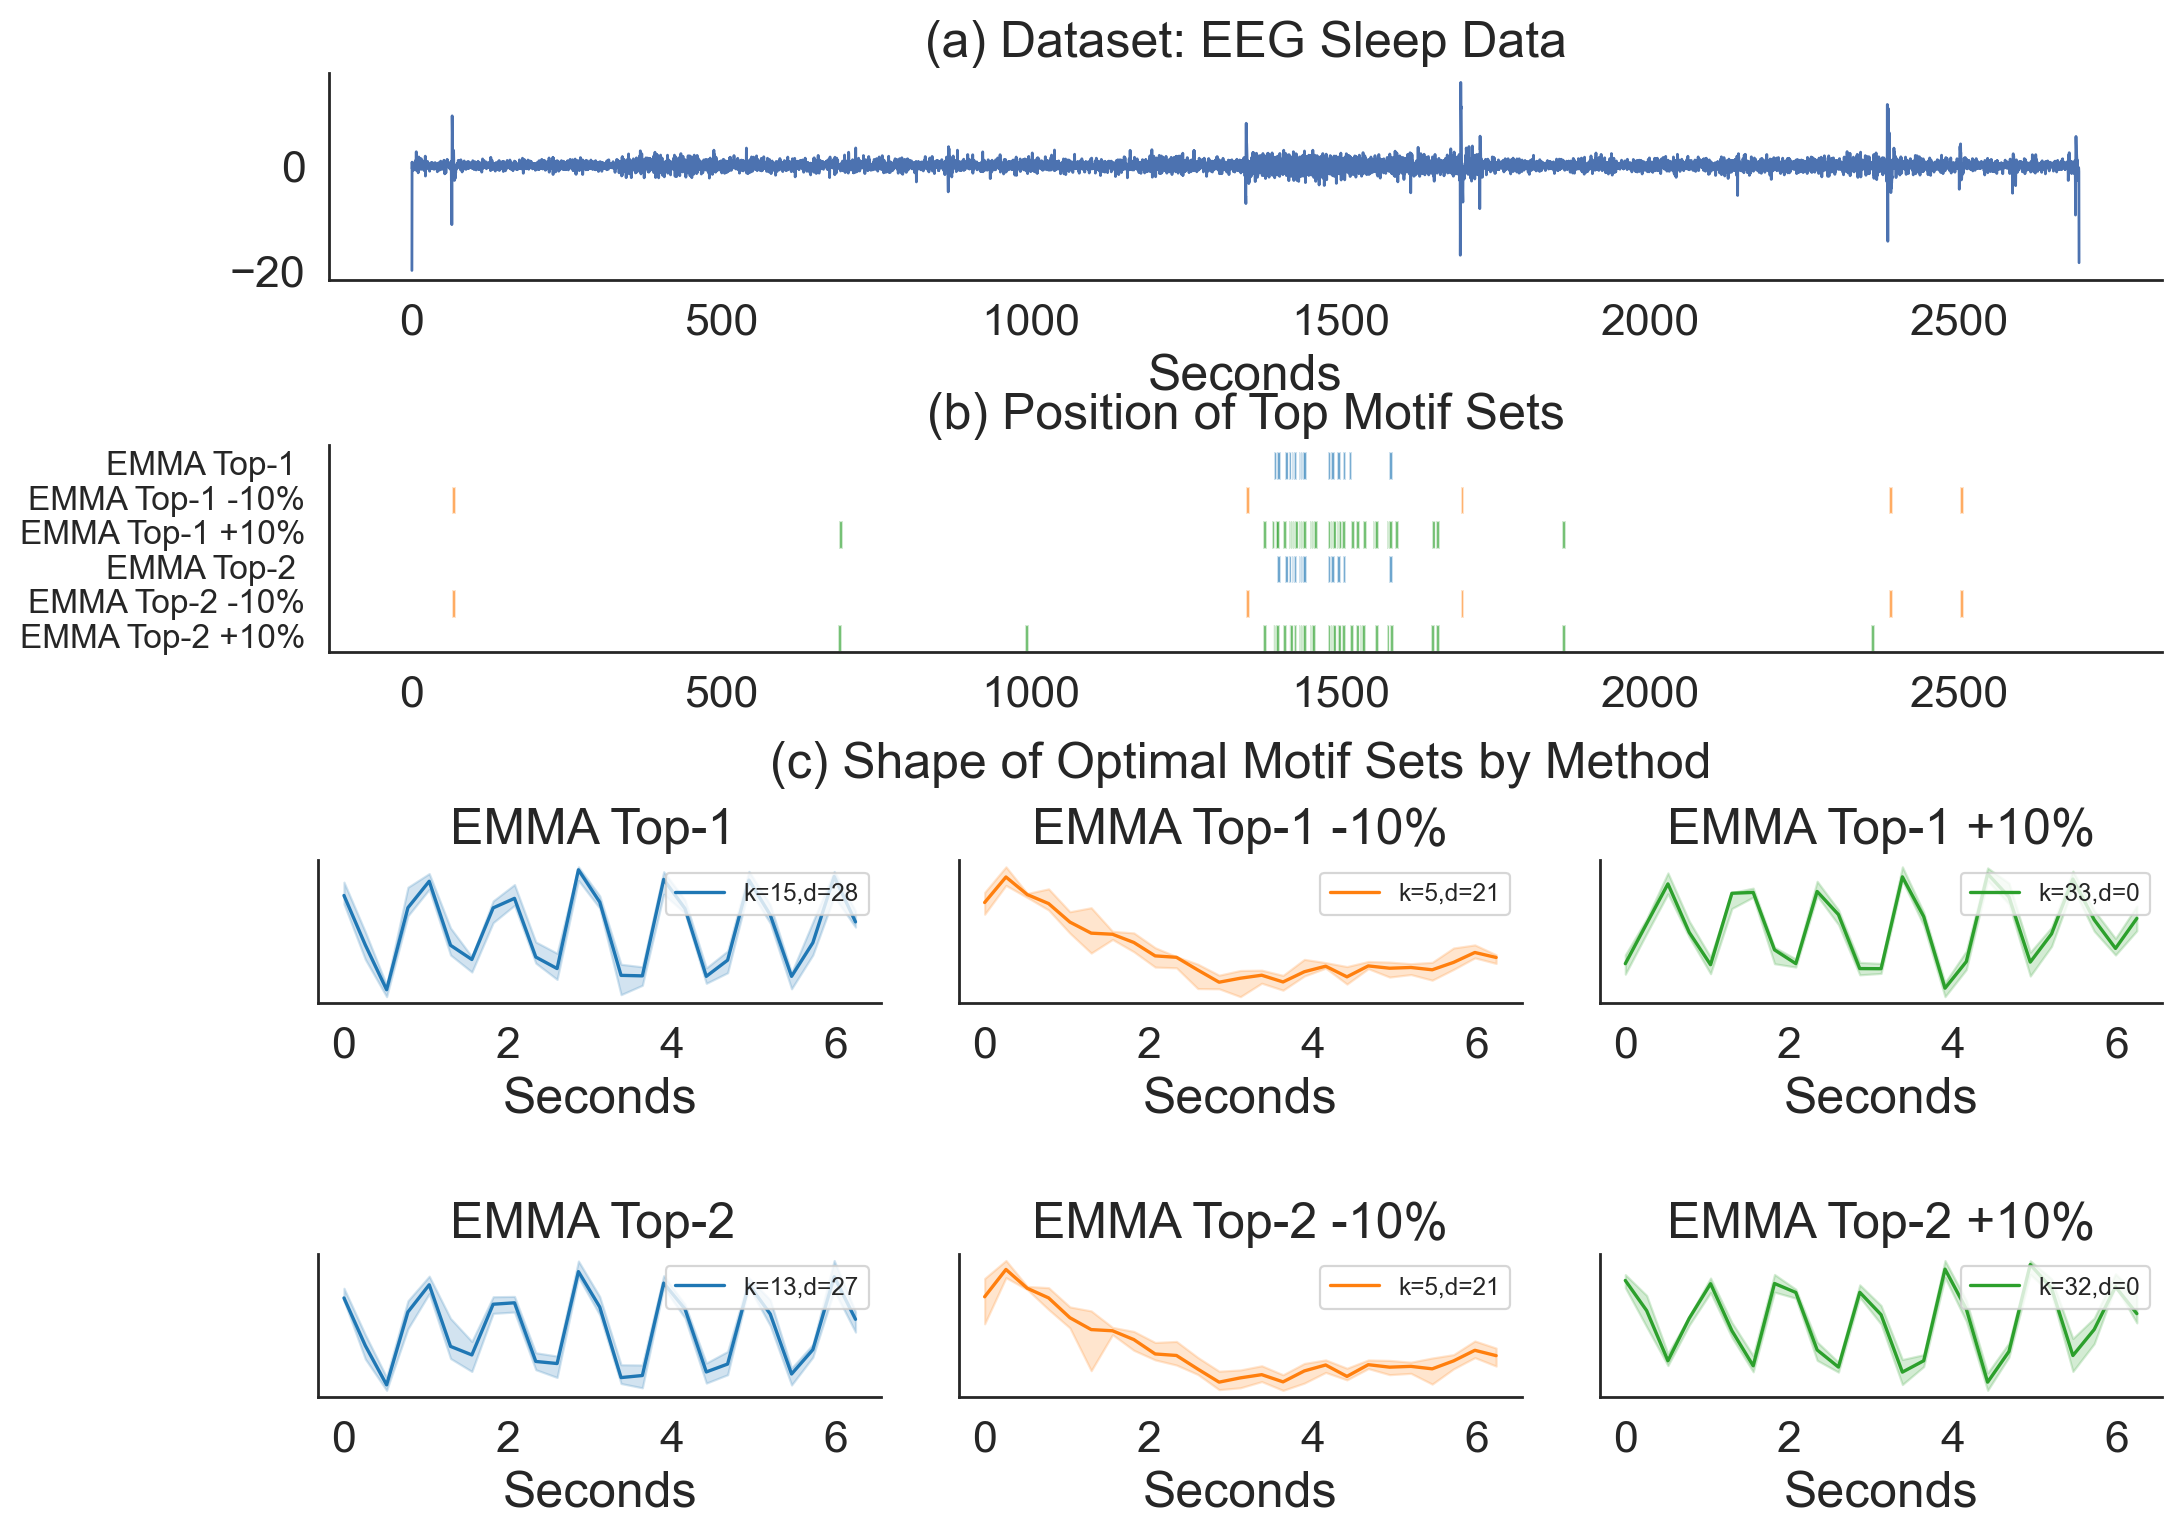

In [9]:
# run jave code first       
ms_all = {
    "" : [
	[5373, 5427, 5446, 5465, 5477, 5510, 5522, 5534, 5694, 5710, 5748, 5782, 6071],
	[5358, 5373, 5427, 5446, 5465, 5477, 5510, 5522, 5534, 5694, 5710, 5748, 5782, 5819, 6071],
    ],
    "-10%" :[
    [250, 5182, 6515, 9176, 9616],
	[250, 5182, 6515, 9176, 9616],
    ],
    "+10%" :[
    [2650, 3808, 5290, 5347, 5358, 5369, 5412, 5446, 5457, 5477, 5510, 5526, 5538, 5578, 5590, 5690, 5710, 5722, 5744, 5756, 5778, 5830, 5866, 5890, 5905, 5983, 6055, 6075, 6333, 6360, 7145, 9066],
	[2652, 5288, 5345, 5360, 5371, 5414, 5448, 5459, 5475, 5487, 5512, 5524, 5536, 5580, 5592, 5603, 5692, 5712, 5724, 5746, 5758, 5780, 5832, 5868, 5907, 5970, 5985, 6057, 6073, 6110, 6335, 6362, 7147],        
    ]
}


motifsets = to_df(ms_all, "EMMA", df, df2)
plot_all_competitors(series, ds_name, motifsets.offsets.values, motif_length,
                     method_names=motifsets.index.values)



EMMA alternates between sleep spindles and noise depending on parameterization and the K-Komplex remains hidden for all parameter configurations.

# Valmod Motif Sets
based on own (fixed-length) implementation

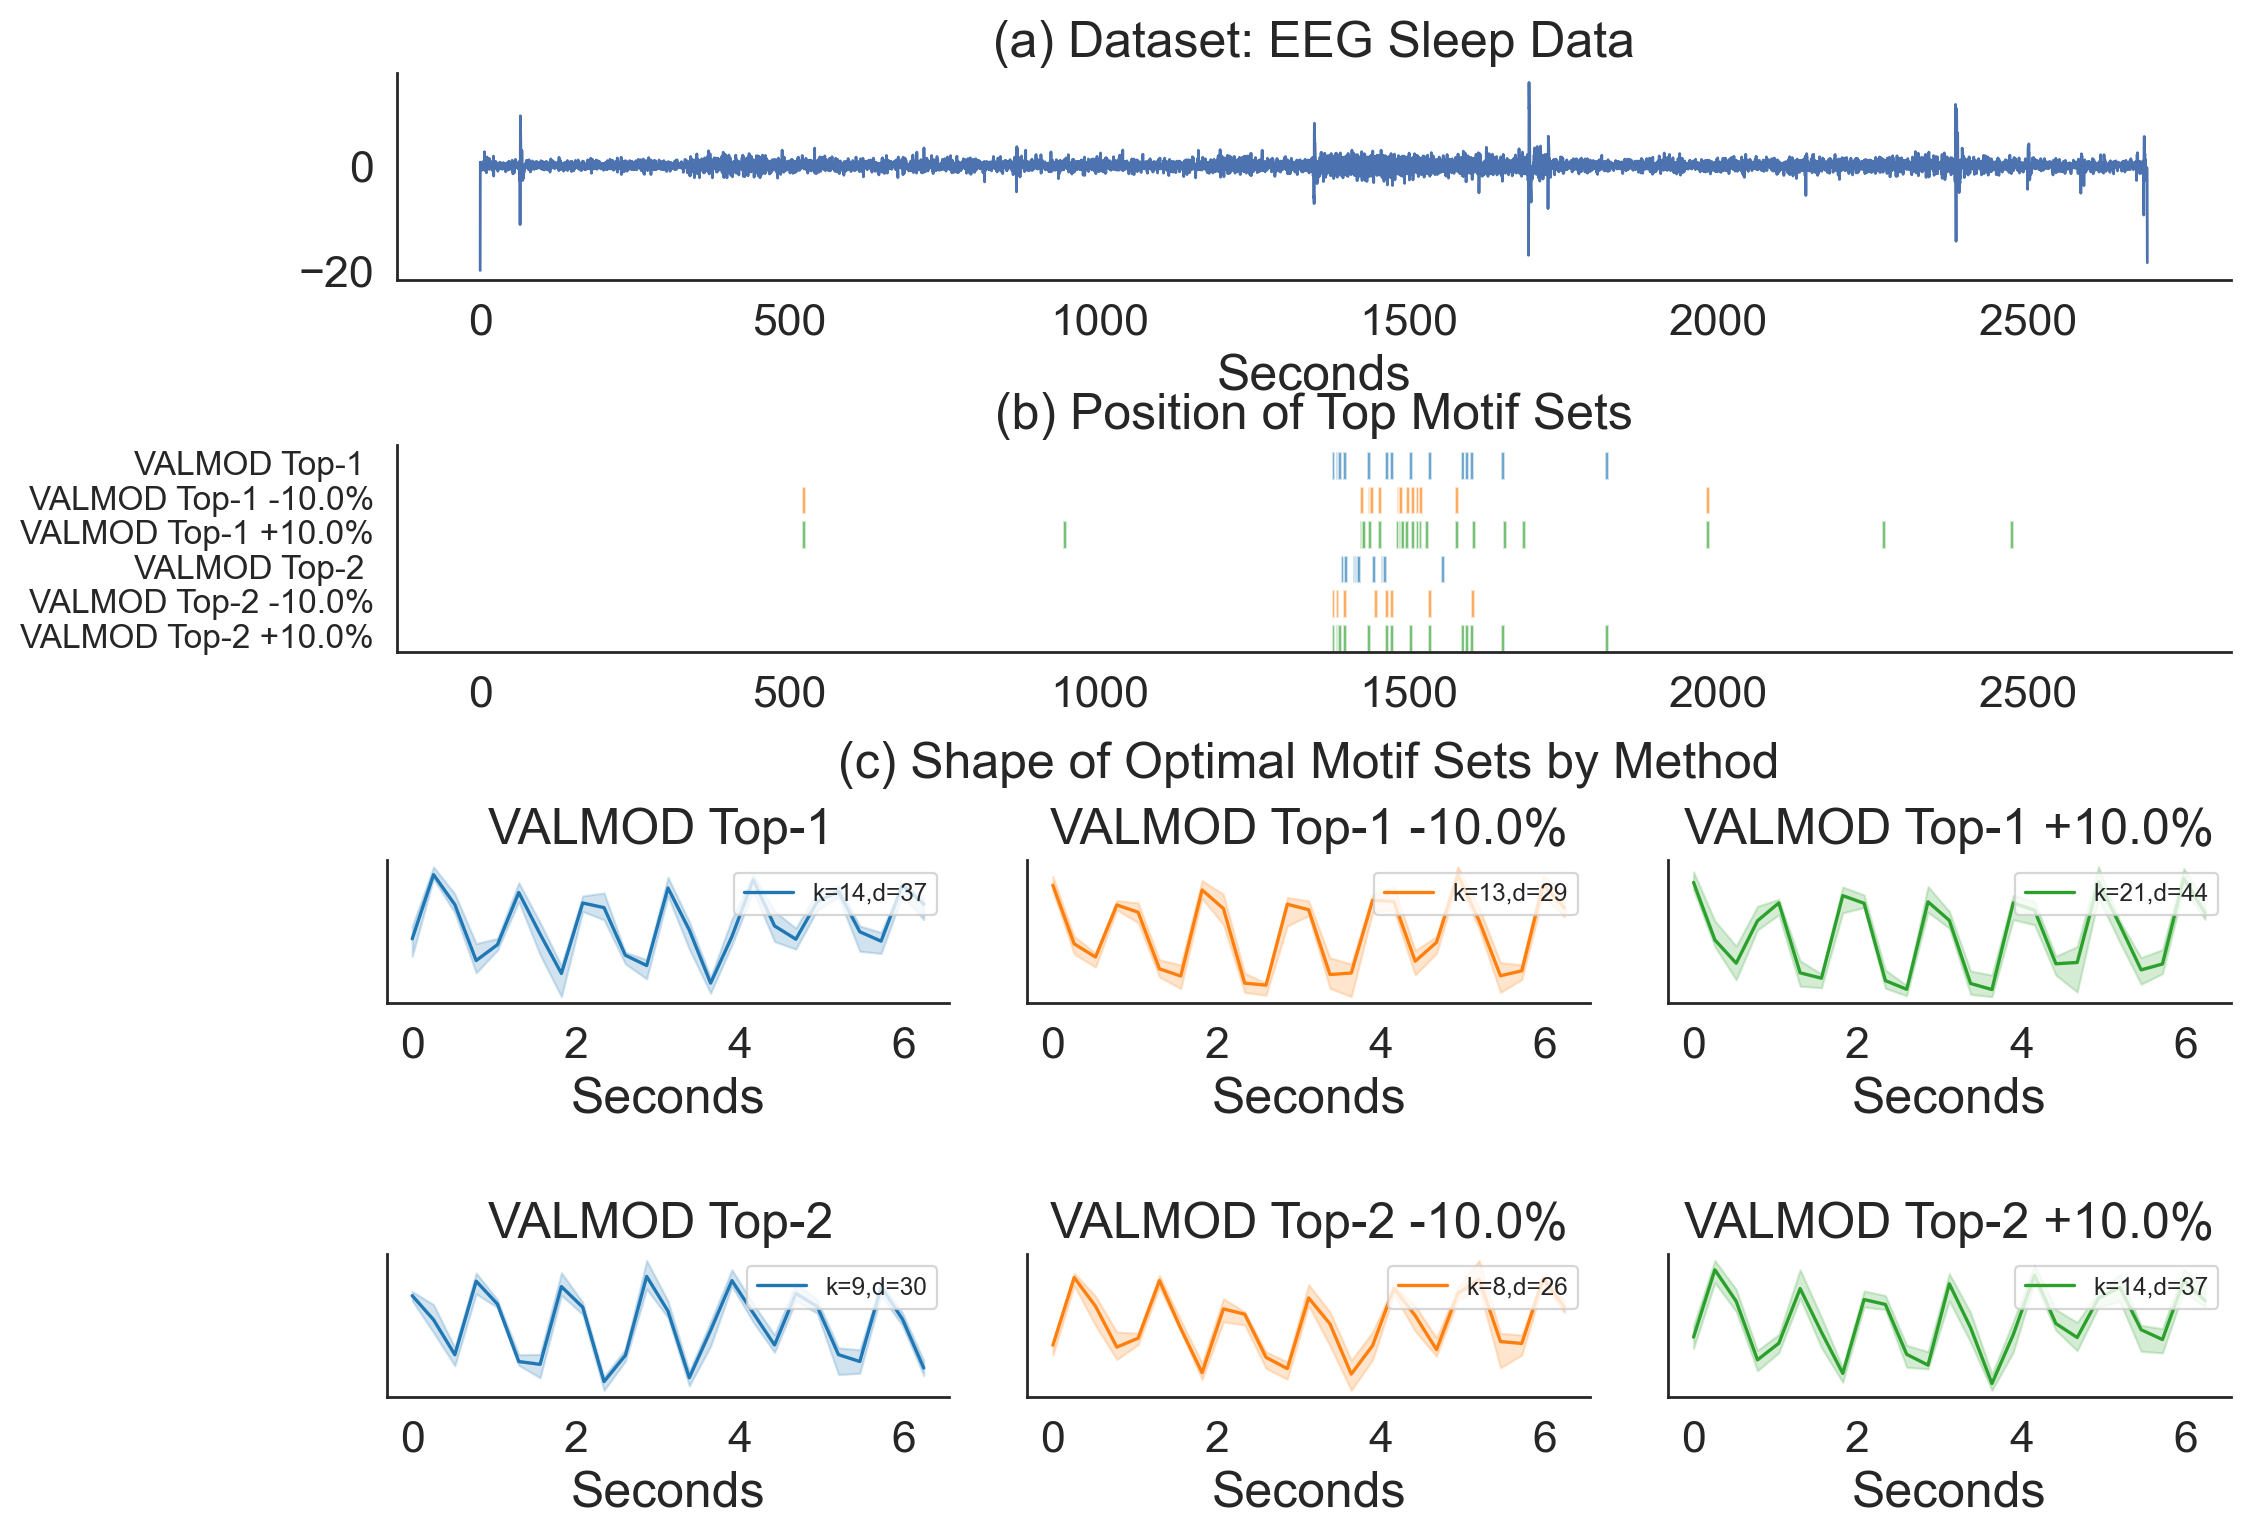

In [10]:
mls = motif_length
max_r=r_top1 *1.52

ms_all = {}
for e in errors:
    rs = max_r * (1.0 * (1+e))
    #mls = np.int32(motif_length * (1-e))
    ms_valmod = list(get_valmod_motif_set_ranged(data, mls, max_r=rs))
    ms_all[format_key(e)] = ms_valmod

motifsets = to_df(ms_all, "VALMOD", df, df2)
plot_all_competitors(series, ds_name, motifsets.offsets.values, motif_length,
                     method_names=motifsets.index.values)


VALMOD stays locked on sleep spindles irrespective of the parameterization.

# Learning Motifs
See Java Code

In [11]:
rs = np.array([r_top2 * 0.95, r_top1 * 0.97])
mls = motif_length

if rerun_all_jars:
    for e in errors:
        rs = rs * (1.0 * (1+e))
        mls = np.int32(motif_length * (1-e))
        output = subprocess.call(['java', '-jar', 
           '../jars/latent_motifs.jar',
           dataset,
           str(list(rs)),
           str(mls)])

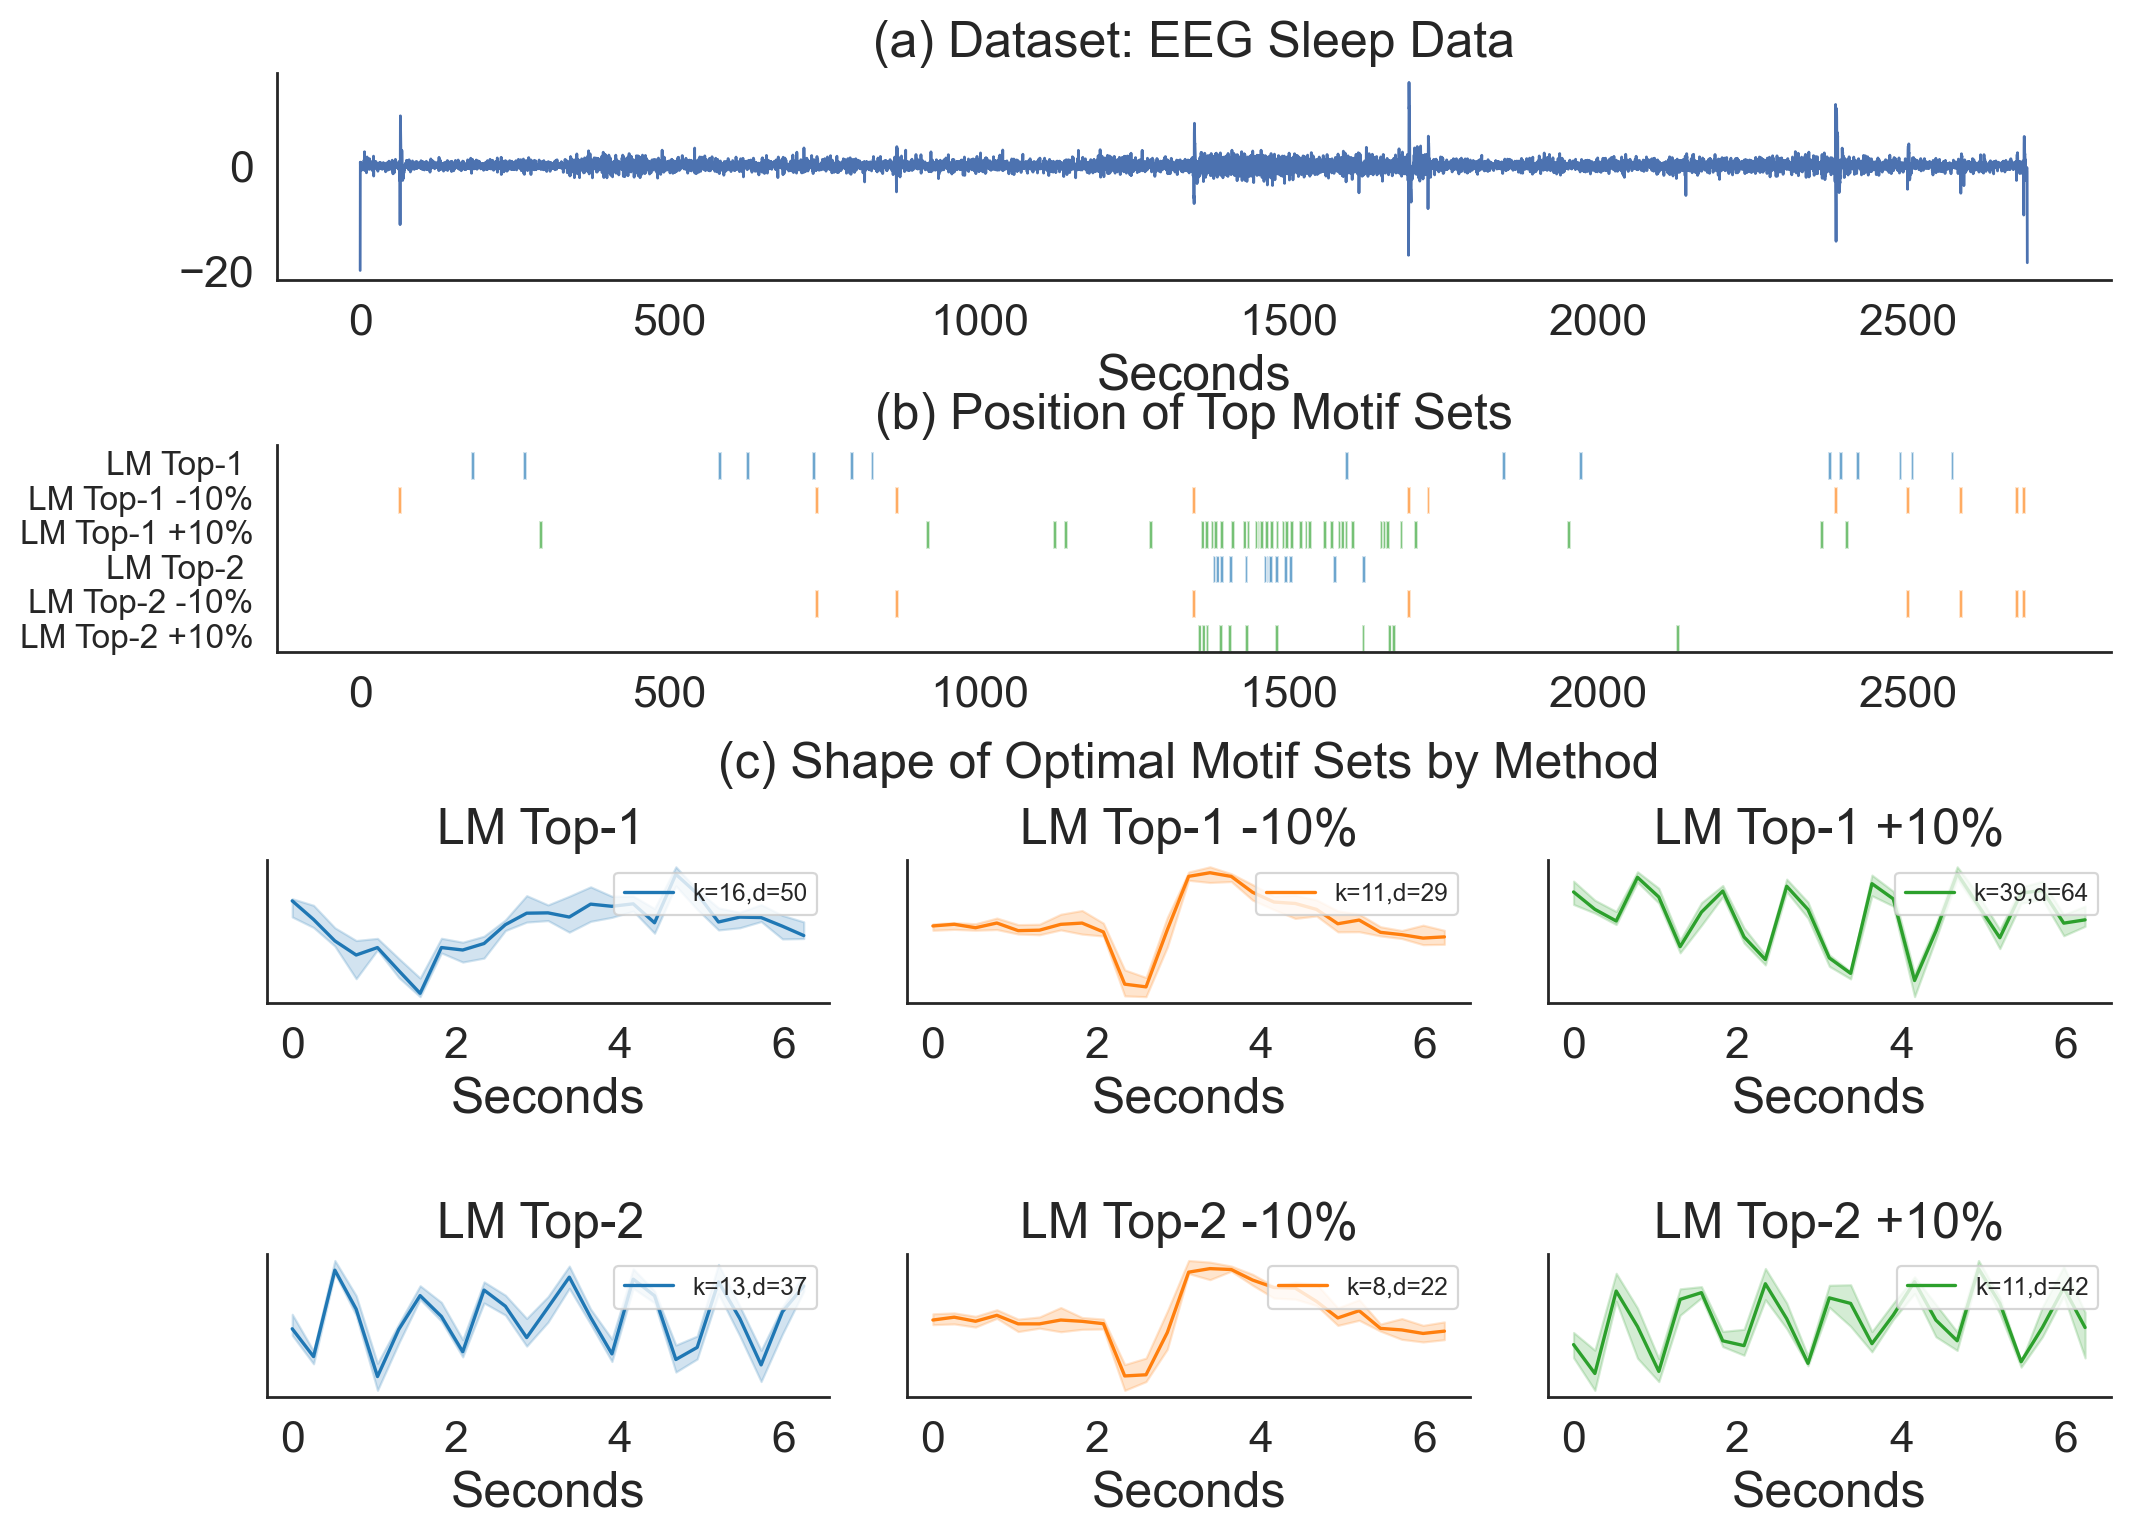

In [12]:
ms_all = {
    "" : [
	[5299,5317,5342,5400,5494,5614,5632,5646,5685,5739,5769,6046,6224,],
	[687,1014,2223,2399,2806,3043,3171,6119,7092,7574,9118,9185,9291,9557,9632,9880,],

    ], 
    "-10%" : [    
    [2825,3322,5170,6504,9604,9935,10280,10325,],
	[238,2825,3322,5170,6504,6625,9159,9604,9935,10280,10325,],        
    ],        
    "+10%" : [
    [5208,5228,5252,5335,5390,5498,5682,6221,6388,6409,8173,],
	[1110,3517,4306,4375,4901,5223,5247,5287,5305,5344,5413,5486,5507,5557,5575,5591,5620,5652,5687,5727,5745,5779,5831,5867,5891,5984,6024,6076,6094,6116,6158,6338,6357,6376,6457,6549,7500,9067,9227,],
    ],
}


motifsets = to_df(ms_all, "LM", df, df2)
plot_all_competitors(series, ds_name, motifsets.offsets.values, motif_length,
                     method_names=motifsets.index.values)



LM alternates between sleep spindles and K-Complexes, but with at most $11$ (out of $13$) occurrences.

# Comparison

We next show a comparison of all methods.

Note that the k-Motiflet algorithm has to recover meaningful motifs without any additional knowledge, while the competitors were provided with inputs with near-optimal parameters, and their results rely heavily on parameterization.

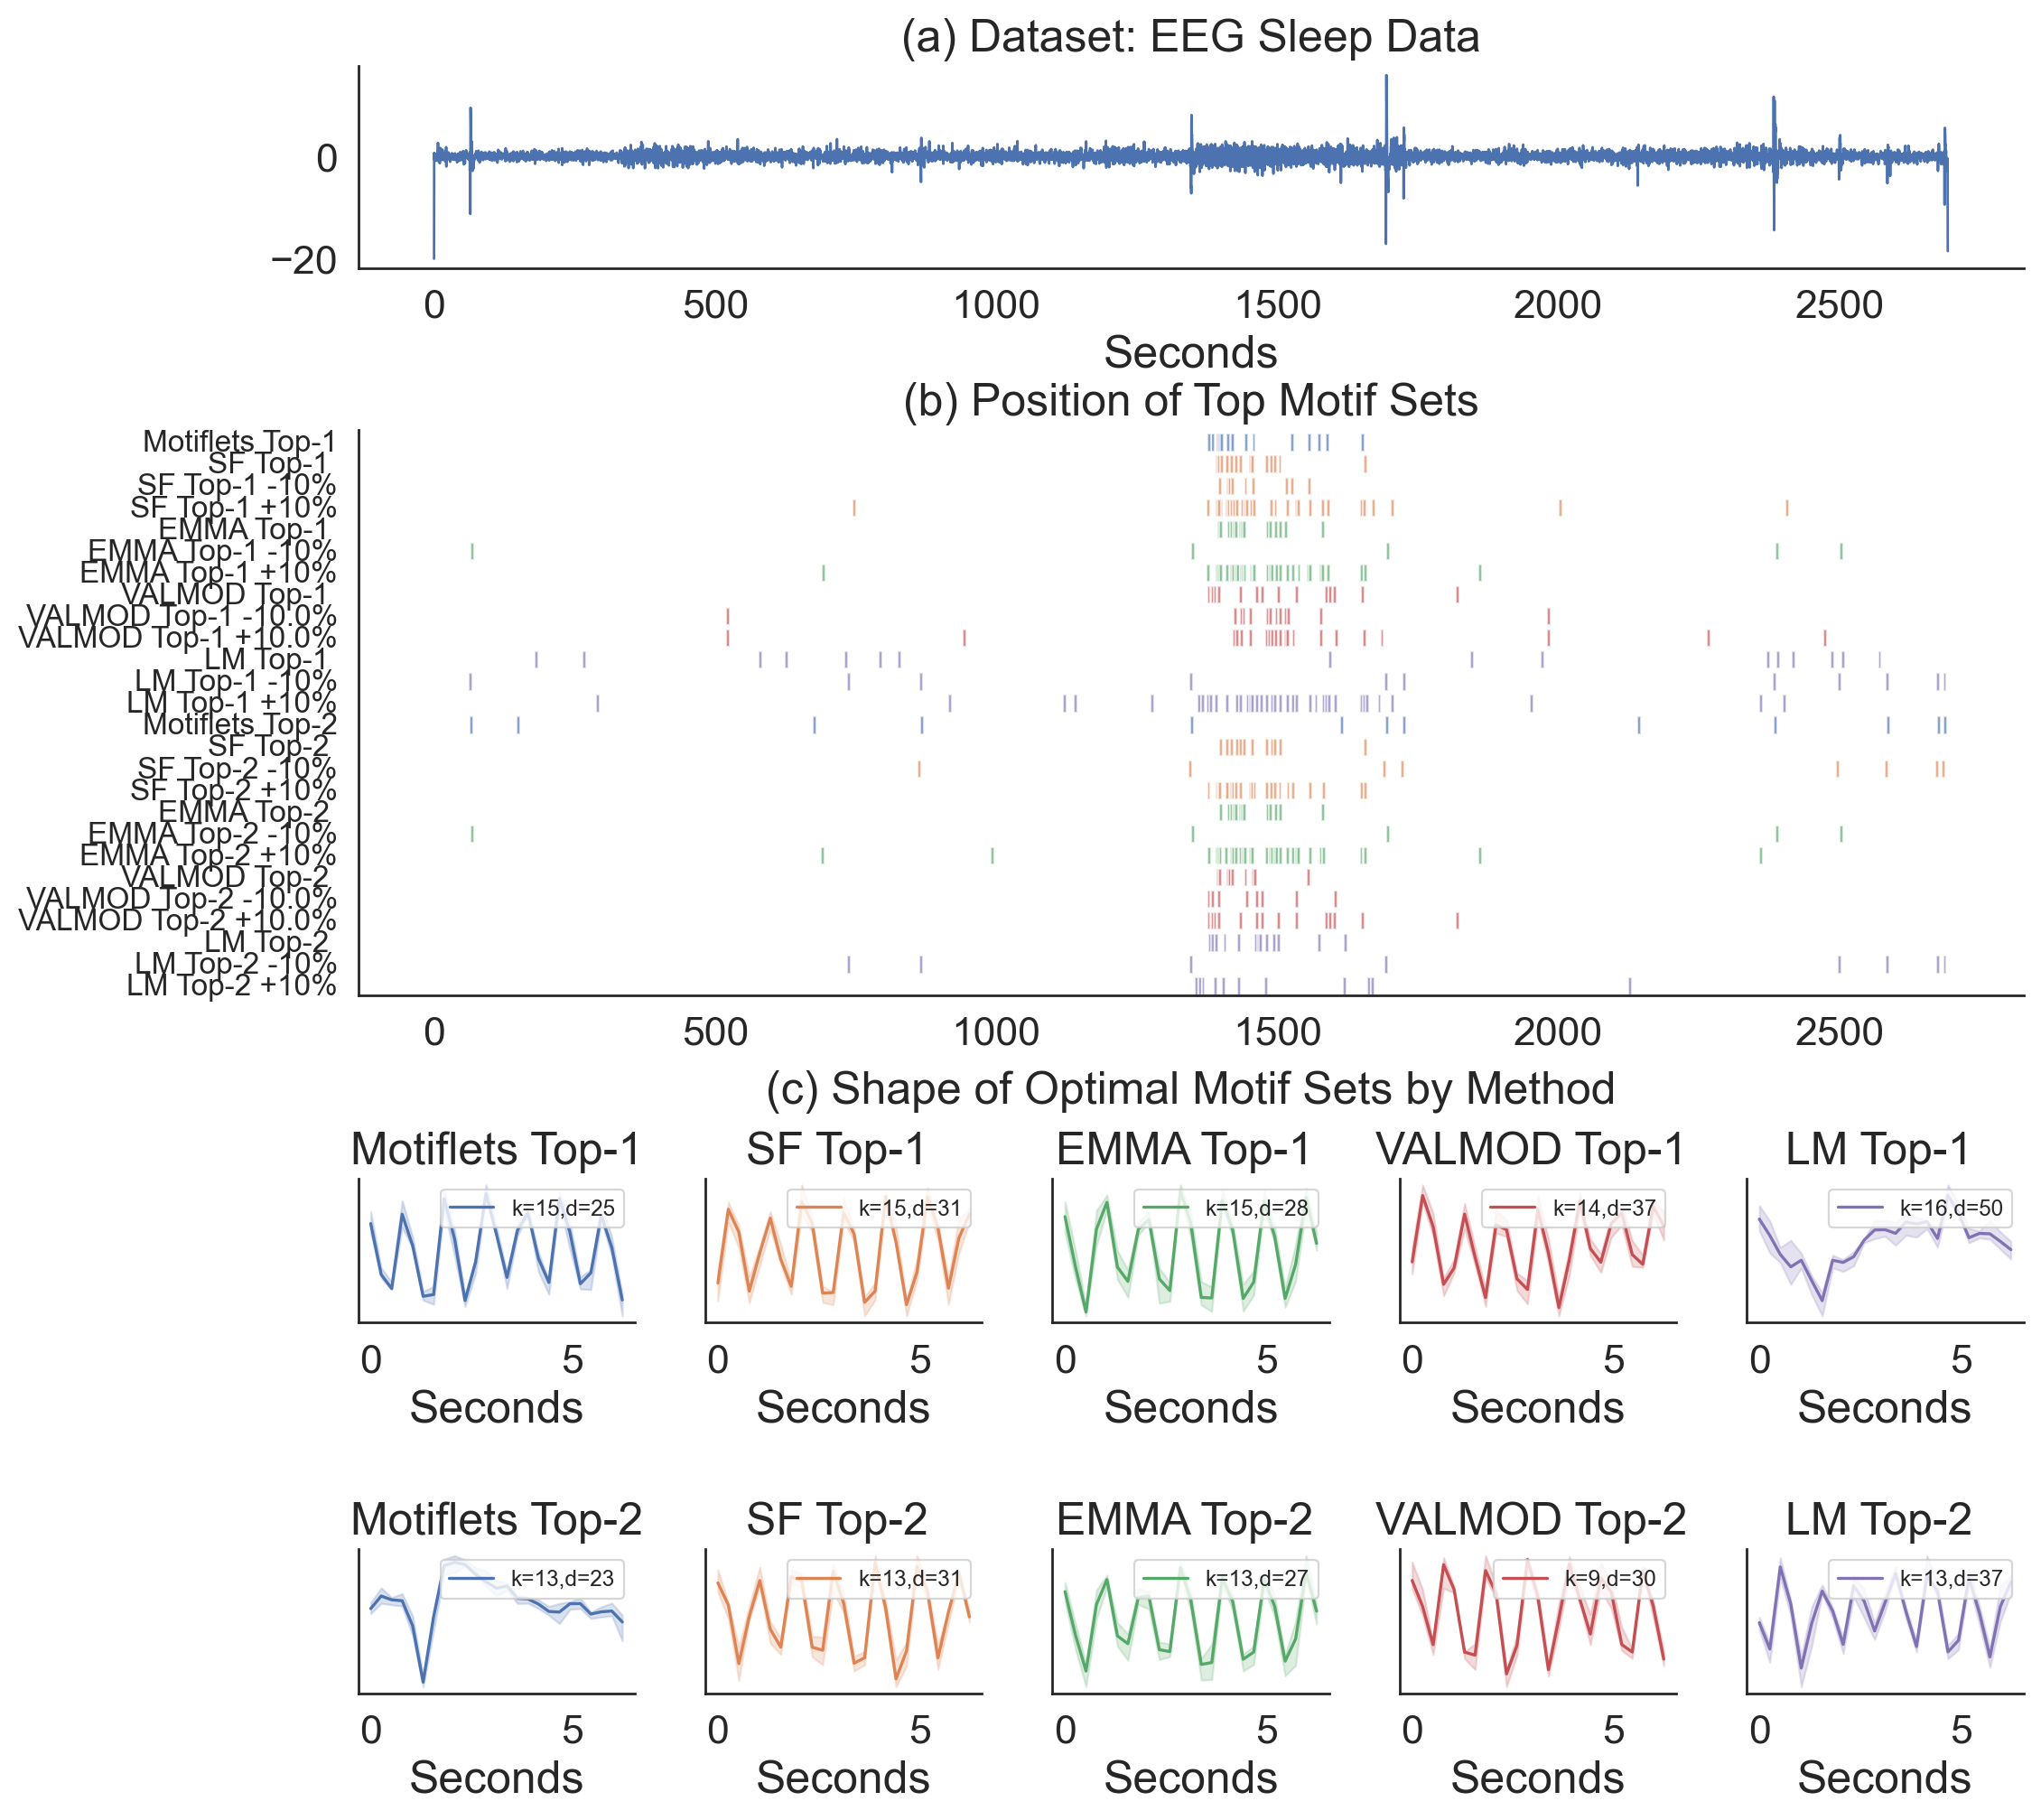

In [13]:
df_all = (pd.concat([df, df2], axis=1)).T
df_all.rename(columns={0:"offsets"}, inplace=True)

index = np.array([0, 1, 2, 3, 4])
color_palette=np.array(sns.color_palette())[index]
plot_index=[0, 1, 4, 7, 10, 13, 14, 17, 20, 23]

motifsets = np.array(df_all["offsets"].values)
plot_all_competitors(series, ds_name, motifsets, motif_length, 
                     color_palette=color_palette,
                     method_names=df_all.index.values, 
                     plot_index=plot_index)            

The bottom part of the plot only shows the shape of the optimal motifs, i.e. with optimal parameterization.

Only $k$-Motiflets and EMMA clearly identify both motifs (sleep spindes and K-Komplex). The k-Motiflet algorithm recovered meaningful motifs without any additional knowledge, while EMMA was provided with inputs with near-optimal parameters.